# Enrichment from FRESCO
7th June 2022 

This notebook is for comparing the enrichment between FRESCO models trained on X-ray fragment-protein complexes vs docked ones

### Load docking conformations

In [1]:
from rdkit.Chem import PandasTools

sdfFile = '/home/wjm41/ml_physics/frag-pcore-screen/data/COVID_Moonshot_activity data_2021-03-22_noncovalent_docked.sdf'
df_docking = PandasTools.LoadSDF(
    sdfFile, idName='canonical_CID', smilesName='SMILES', molColName='mol')


INFO:rdkit:Enabling RDKit 2022.03.1 jupyter extensions


,index,canonical_CID,SMILES,mol,series,Chemgauss4 Score,f_avg_pIC50,f_avg_IC50,chloroacetamide,acrylamide,Number of Confs,r_inhibition_at_50_uM,r_avg_IC50,relative_solubility_at_100_uM,relative_solubility_at_20_uM,f_inhibition_at_50_uM,f_inhibition_at_20_uM,r_inhibition_at_20_uM,trypsin_IC50,frag_id
0,1,EDG-MED-ba1ac7b9-15,C[C@@H]1CN(C)CCN1C(=O)C[C@@]1(C(=O)Nc2cncc3ccc...,,3-aminopyridine-like,-12.6986,5.20921,6.17716,False,False,38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,MAT-POS-9ff17035-2,O=C(Cc1cc(Cl)cc(Oc2cccc(=O)[nH]2)c1)Nc1cncc2cc...,,3-aminopyridine-like,-12.43,5.70429,1.97563,False,False,500,41.805,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,EDJ-MED-8c98ee63-2,Cn1ccc(CNC[C@@]2(C(=O)Nc3cncc4ccccc34)CCOc3ccc...,,3-aminopyridine-like,-12.3919,6.09539,0.802811,False,False,500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,ALP-POS-64a710fa-1,O=C(Cc1cncc2ccccc12)N(CCC1CCCCC1)Cc1cccs1,,NaN,-12.3789,5.00607,9.86113,False,False,500,NaN,3.02151,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,BAR-COM-4e090d3a-3,Cc1ccccc1CNc1ccccc1NC(=O)[C@@H](O)c1cccnc1,,3-aminopyridine-like,-12.3516,NaN,NaN,False,False,500,35.735,NaN,0.94,0.95,7.28047,-0.0560025,4.5875,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2533,2654,ALP-POS-305f6ec3-52,CC(C)(C)c1ccc(N(C(=O)c2c[nH]c(=O)[nH]2)[C@@H](...,,Ugi,3.0553,4.79812,15.9178,False,False,74,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2534,2655,ALP-POS-88a7a97e-23,COC(=O)[C@@H]1C[C@@H](NC(=O)[C@H](c2cccnc2)N(C...,,NaN,3.38598,5.16595,6.82414,False,False,106,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2535,2656,ALP-POS-b0bc6a46-27,N#Cc1cc(N(C(=O)c2ccco2)[C@@H](C(=O)NCCc2cccc(F...,,NaN,3.53119,NaN,99.5,False,False,500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2536,2657,BRU-THA-92256091-77,O=C(NCCc1cccc(F)c1)[C@H](c1cccnc1)N(C(=O)c1c[n...,,NaN,4.22059,4.32089,47.765,False,False,44,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

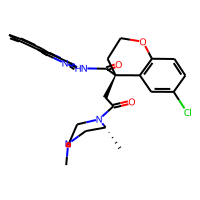
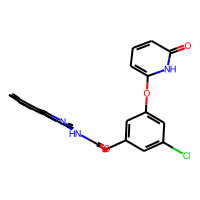
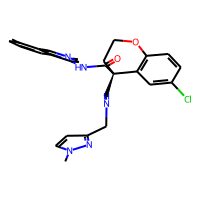
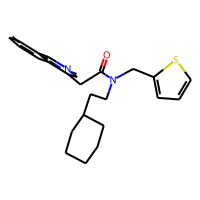
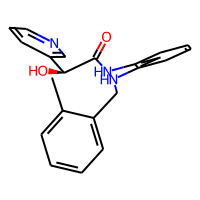
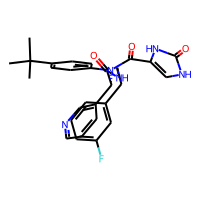
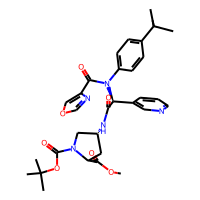
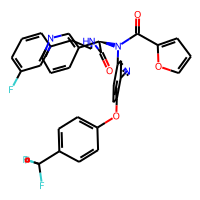
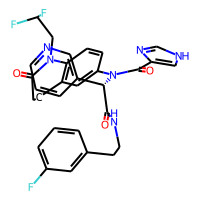
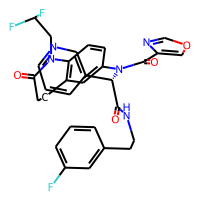

In [2]:
from distutils.util import strtobool

df_docking = df_docking.dropna(subset=['acrylamide'])
df_docking['acrylamide'] = df_docking['acrylamide'].apply(
    strtobool).astype(bool)
df_docking['chloroacetamide'] = df_docking['chloroacetamide'].apply(
    strtobool).astype(bool)

df_docking = df_docking.query('~chloroacetamide & ~acrylamide').reset_index()
df_docking

Generate pharmacophore dataframe from conformers
parse conformers

In [3]:
from fresco.featurise import return_pcore_dataframe_for_list_of_mols

moonshot_pcore_dataframe = return_pcore_dataframe_for_list_of_mols(df_docking['mol'].values)
moonshot_pcore_dataframe


100%|██████████| 2538/2538 [00:32<00:00, 79.22it/s] 


,pcore,smiles,mol_id,coord_x,coord_y,coord_z
0,Donor,C[C@@H]1CN(C)CCN1C(=O)C[C@@]1(C(=O)Nc2cncc3ccc...,0,8.706100,-3.282500,24.817800
0,Donor,C[C@@H]1CN(C)CCN1C(=O)C[C@@]1(C(=O)Nc2cncc3ccc...,0,6.785400,-4.799400,26.467600
0,Donor,C[C@@H]1CN(C)CCN1C(=O)C[C@@]1(C(=O)Nc2cncc3ccc...,0,7.780500,-0.126000,21.171800
0,Acceptor,C[C@@H]1CN(C)CCN1C(=O)C[C@@]1(C(=O)Nc2cncc3ccc...,0,6.594600,0.190600,17.701700
0,Acceptor,C[C@@H]1CN(C)CCN1C(=O)C[C@@]1(C(=O)Nc2cncc3ccc...,0,9.923300,0.106100,20.227800
...,...,...,...,...,...,...
0,Acceptor,O=C(NCCc1cccc(F)c1)[C@H](c1cccnc1)N(C(=O)c1coc...,2537,5.232900,-7.223200,27.364600
0,Aromatic,O=C(NCCc1cccc(F)c1)[C@H](c1cccnc1)N(C(=O)c1coc...,2537,11.660640,0.511120,24.741700
0,Aromatic,O=C(NCCc1cccc(F)c1)[C@H](c1cccnc1)N(C(=O)c1coc...,2537,6.833800,-5.037117,27.731300
0,Aromatic,O=C(NCCc1cccc(F)c1)[C@H](c1cccnc1)N(C(=O)c1coc...,2537,5.819533,-0.802667,24.718817


Generate pharmacophore 2-body distribution

In [4]:
from fresco.featurise import return_default_pharmacophore_pairs, calculate_pairwise_distances_between_pharmacophores_for_a_single_ligand

pcore_pairs = return_default_pharmacophore_pairs()

moonshot_pair_distributions = []
for index in tqdm(moonshot_pcore_dataframe.mol_id.unique()):
    pair_distribution_for_this_ligand = {}
    
    for pcore_pair in pcore_pairs:
        core_a,core_b = pcore_pair.split('-')
        pair_distribution_for_this_ligand[pcore_pair] = calculate_pairwise_distances_between_pharmacophores_for_a_single_ligand(
            moonshot_pcore_dataframe.query('mol_id == @index'), core_a, core_b)

    moonshot_pair_distributions.append(pair_distribution_for_this_ligand)


100%|██████████| 2538/2538 [01:12<00:00, 35.03it/s]


Load fragment KDEs

In [5]:
import dill as pickle
from fresco.model import load_kde_model

pickle_dir = '/home/wjm41/ml_physics/frag-pcore-screen/data/EnamineREAL/pickles/'
xray_kde_mpro = 'kde_dict_spl_mpro.pickle'
xray_kde_dict = pickle.load(open(pickle_dir+xray_kde_mpro, 'rb'))

random_kde_mpro = '/home/wjm41/ml_physics/frag-pcore-screen/data/kde_on_random_mpro_frags.pkl'
random_kde_dict = load_kde_model(random_kde_mpro)

docked_kde_mpro = '/home/wjm41/ml_physics/frag-pcore-screen/data/kde_on_docked_mpro_frags.pkl'
docked_kde_dict = load_kde_model(docked_kde_mpro)

docked_5_kde_mpro = '/home/wjm41/ml_physics/frag-pcore-screen/data/kde_on_5_docked_mpro_frags.pkl'
docked_5_kde_dict = load_kde_model(docked_5_kde_mpro)

docked_dsi_kde = '/home/wjm41/ml_physics/frag-pcore-screen/data/kde_on_docked_dsi_frags.pkl'
docked_dsi_kde_dict = load_kde_model(docked_dsi_kde)

Score moonshot mols with KDEs

,index,canonical_CID,SMILES,mol,series,Chemgauss4 Score,f_avg_pIC50,f_avg_IC50,chloroacetamide,acrylamide,...,f_inhibition_at_50_uM,f_inhibition_at_20_uM,r_inhibition_at_20_uM,trypsin_IC50,frag_id,xray_fresco_score,random_fresco_score,docked_fresco_score,docked_5_fresco_score,docked_dsi_fresco_score
0,1,EDG-MED-ba1ac7b9-15,C[C@@H]1CN(C)CCN1C(=O)C[C@@]1(C(=O)Nc2cncc3ccc...,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",3-aminopyridine-like,-12.6986,5.20921,6.17716,False,False,...,NaN,NaN,NaN,NaN,NaN,-1.956048,-1.568535,-1.927443,-1.879116,-1.815833
1,2,MAT-POS-9ff17035-2,O=C(Cc1cc(Cl)cc(Oc2cccc(=O)[nH]2)c1)Nc1cncc2cc...,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",3-aminopyridine-like,-12.43,5.70429,1.97563,False,False,...,NaN,NaN,NaN,NaN,NaN,-1.955927,-1.820553,-1.971900,-2.001098,-1.956925
2,3,EDJ-MED-8c98ee63-2,Cn1ccc(CNC[C@@]2(C(=O)Nc3cncc4ccccc34)CCOc3ccc...,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",3-aminopyridine-like,-12.3919,6.09539,0.802811,False,False,...,NaN,NaN,NaN,NaN,NaN,-1.987350,-1.671622,-1.859249,-1.848437,-1.826173
3,4,ALP-POS-64a710fa-1,O=C(Cc1cncc2ccccc12)N(CCC1CCCCC1)Cc1cccs1,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",NaN,-12.3789,5.00607,9.86113,False,False,...,NaN,NaN,NaN,NaN,NaN,-2.639950,-2.420212,-2.545335,-2.744855,-2.760389
4,5,BAR-COM-4e090d3a-3,Cc1ccccc1CNc1ccccc1NC(=O)[C@@H](O)c1cccnc1,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",3-aminopyridine-like,-12.3516,NaN,NaN,False,False,...,7.28047,-0.0560025,4.5875,NaN,NaN,-2.095374,-1.733485,-1.852797,-1.915045,-1.796295
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2533,2654,ALP-POS-305f6ec3-52,CC(C)(C)c1ccc(N(C(=O)c2c[nH]c(=O)[nH]2)[C@@H](...,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",Ugi,3.0553,4.79812,15.9178,False,False,...,NaN,NaN,NaN,NaN,NaN,-1.978760,-1.646912,-1.818253,-1.845265,-1.802240
2534,2655,ALP-POS-88a7a97e-23,COC(=O)[C@@H]1C[C@@H](NC(=O)[C@H](c2cccnc2)N(C...,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",NaN,3.38598,5.16595,6.82414,False,False,...,NaN,NaN,NaN,NaN,NaN,-2.149193,-1.696592,-1.844638,-1.836213,-1.835609
2535,2656,ALP-POS-b0bc6a46-27,N#Cc1cc(N(C(=O)c2ccco2)[C@@H](C(=O)NCCc2cccc(F...,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",NaN,3.53119,NaN,99.5,False,False,...,NaN,NaN,NaN,NaN,NaN,-2.488512,-2.409595,-2.402487,-2.710506,-2.712887
2536,2657,BRU-THA-92256091-77,O=C(NCCc1cccc(F)c1)[C@H](c1cccnc1)N(C(=O)c1c[n...,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",NaN,4.22059,4.32089,47.765,False,False,...,NaN,NaN,NaN,NaN,NaN,-1.943882,-1.649431,-1.804992,-1.843634,-1.835066

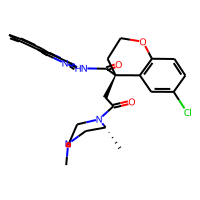
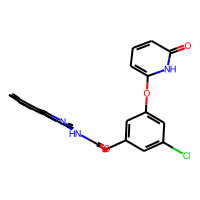
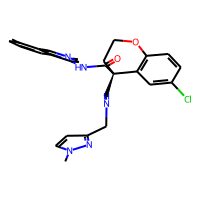
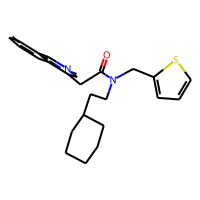
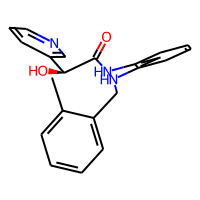
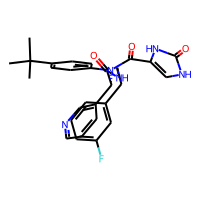
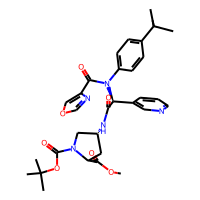
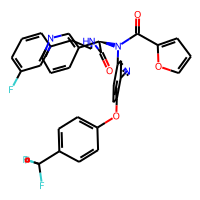
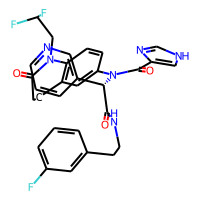
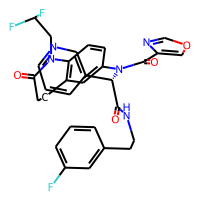

In [6]:
import numpy as np
import pandas as pd
from fresco.model import score_dist

def score_dist_new(kde, dist):
    if len(dist):  # non-zero length

        # log-prob (larger = higher prob)
        score = kde(dist.reshape(-1, 1))

        score = np.max(score)

        return score
    else:
        return np.nan


def score_with_kde(kde_model, col_name):
    
    df_docking[col_name] = -100.0
    for i, pair_dist in enumerate(moonshot_pair_distributions):

        score_df_for_this_molecule = pd.DataFrame(columns=pcore_pairs)
        
        for pcore_combination in pcore_pairs:
            kde_for_this_combination = kde_model[pcore_combination]
            # print(pair_dist[pcore_combination])
            pcore_dist = pair_dist[pcore_combination].reshape(
                -1, 1)
            pcore_score = score_dist_new(kde_for_this_combination, pcore_dist)
            score_df_for_this_molecule.at[0, pcore_combination] = pcore_score

        scores = score_df_for_this_molecule[pcore_pairs].to_numpy().astype(
            float)
        # scores[np.isnan(scores)] = -100
        processed_score_for_this_molecule = np.nanmean(scores)
        df_docking.at[i, col_name] = processed_score_for_this_molecule
        
score_with_kde(xray_kde_dict, 'xray_fresco_score')
score_with_kde(random_kde_dict, 'random_fresco_score')
score_with_kde(docked_kde_dict, 'docked_fresco_score')
score_with_kde(docked_5_kde_dict, 'docked_5_fresco_score')
score_with_kde(docked_dsi_kde_dict, 'docked_dsi_fresco_score')

df_docking


Average fragment scores over conformers

In [7]:
df_docking.f_avg_IC50 = df_docking.f_avg_IC50.astype(float)
df_docking['Chemgauss4 Score'] = df_docking['Chemgauss4 Score'].astype(float)

fresco_scores = ['xray_fresco_score', 'random_fresco_score', 'docked_fresco_score', 'docked_5_fresco_score', 'docked_dsi_fresco_score']

columns_to_keep = ['canonical_CID',
                   'Chemgauss4 Score', 'f_avg_IC50'] + fresco_scores
df_docking = df_docking[columns_to_keep]
df_docking_grouped = df_docking.groupby(by=df_docking.canonical_CID).mean()
df_docking_grouped['canonical_CID'] = df_docking_grouped.index

df_docking_grouped['hit'] = df_docking_grouped['f_avg_IC50'] < 5
print(df_docking_grouped[['hit', 'f_avg_IC50',
      'Chemgauss4 Score'] + fresco_scores].sort_values(by='xray_fresco_score', ascending=False))



                       hit  f_avg_IC50  Chemgauss4 Score  xray_fresco_score  \
canonical_CID                                                                 
CHO-MSK-00c5269a-2    True    1.137760          -7.89468          -1.858081   
LON-WEI-4d77710c-76   True    0.221232          -4.72356          -1.865079   
ALP-POS-c0c213c9-15  False   99.500000          -6.87643          -1.866165   
ALP-POS-7c842ab8-1   False   99.500000          -8.01683          -1.868125   
MAT-POS-9db1e783-3    True    4.357510          -9.57854          -1.871992   
...                    ...         ...               ...                ...   
AAR-RCN-845f9611-1   False   99.500000          -7.93705          -3.748758   
AAR-RCN-78cf61f7-1   False   99.500000          -7.18020          -3.828434   
AAR-RCN-28a8122f-1   False   99.500000          -7.61163          -3.833346   
LON-WEI-ff7b210a-11  False         NaN          -7.36039          -4.703167   
AAR-RCN-9f0de475-1   False   99.500000          -4.8

Getting submission dates

In [8]:
dateFile = '/home/wjm41/ml_physics/frag-pcore-screen/data/20220122_moonshot_submissions_data_for_alpha.csv'
df_date = pd.read_csv(dateFile)

def remove_suffix(id):
    id_separated = id.split('-')[:-1]
    new_id = '-'.join(id_separated)
    return new_id

df_docking_grouped['submission_id'] = df_docking_grouped['canonical_CID'].apply(remove_suffix)
df_merged = df_docking_grouped.merge(df_date, on='submission_id')
df_merged['Neg Dock Score'] = df_merged['Chemgauss4 Score']*-1


Enrichment against time

In [9]:
from ipywidgets import interact
from scipy.stats import spearmanr as spear
import plotly.express as px

from fresco.frag_funcs import calculate_enrichment_for_df

def return_enrichment_df(df_to_calculate, col_name, method_name, n_list):
    enrichment_list = [calculate_enrichment_for_df(
        df_to_calculate, n=int(n), index='hit', score=col_name, ascending=False) for n in n_list]
    
    df_ef = pd.DataFrame(list(zip(n_list, enrichment_list)), columns=[
        'N', 'EF'])
    df_ef['Method'] = method_name
    return df_ef


def plotly_enrichment_docking_vs_fresco(df_to_plot, title='Not Specified!'):

    starting_number = 10
    stop_number = 100
    n_list = np.linspace(start=starting_number, stop=stop_number,
                        num=stop_number-starting_number, endpoint=False)

    
    orig_prop = 100*len(
        df_to_plot[df_to_plot['hit']])/len(df_to_plot)
    col_and_method_names = {'Neg Dock Score': 'Docking',
                            # 'random_fresco_score': 'Fresco - random',
                            'xray_fresco_score': 'Fresco - Xray',
                            'docked_fresco_score': 'Fresco - Docked',
                            'docked_5_fresco_score': 'Fresco - Docked 5',
                            'docked_dsi_fresco_score': 'Fresco - DSI'
                            }
    
    df_enrichment = []
    for col, method in col_and_method_names.items():
        df_ef = return_enrichment_df(df_to_plot, col, method, n_list)
        df_enrichment.append(df_ef)
    EF_both = []
    for n in n_list:
        df_ranked = df_to_plot.copy()
        df_ranked['dock_rank'] = df_ranked['Neg Dock Score'].rank(ascending=False)
        df_ranked['fresco_rank'] = df_ranked['xray_fresco_score'].rank(ascending=False)
        df_ranked['both_rank'] = df_ranked[['dock_rank','fresco_rank']].min(axis=1)
        # print(df_ranked)
        # bigger is better
        EF_both.append(calculate_enrichment_for_df(df_ranked, n=int(
            n), index='hit', score='both_rank', ascending=False))
        
    df_both_ef = pd.DataFrame(list(zip(n_list, EF_both)), columns=[
        'N', 'EF'])
    df_both_ef['Method'] = 'Both'
    df_enrichment.append(df_both_ef)
    df_enrichment = pd.concat(df_enrichment)
    
    df_enrichment['hit rate'] = df_enrichment['EF']*orig_prop
    # fig_hit = px.line(df_enrichment, x='N', y='hit rate',
    #                  color='Method')
    fig_hit = px.line(df_enrichment, x='N', y='hit rate',
                     color='Method')
    fig_hit.add_shape(
        type="line", line=dict(dash='dash'),
        x0=min(n_list), y0=orig_prop,
        x1=max(n_list), y1=orig_prop)
    
    fig_hit.update_layout(
        title_text=f"Enrichment - {title}",
        xaxis_title='N',
        yaxis_title=f'Hit rate <br>n = {len(df_to_plot)} <br> base rate = {orig_prop:.1f}%',
        width=800,
    )

    fig_hit.show()


def plot_enrichment_against_time(year='2020', month='09', day='01', ic50_threshold=5.0):
    date_to_filter = int(f'{year}{month}{day}')
    df_filtered_by_date = df_merged.query('date < @date_to_filter').copy()
    df_filtered_by_date['hit'] = df_filtered_by_date['f_avg_IC50'] < ic50_threshold
    # print(df_filtered_by_date.query('hit'))
    plotly_enrichment_docking_vs_fresco(df_filtered_by_date,
                                        title=f'IC50 < {ic50_threshold}uM<br>COVID Moonshot submissions before {day}-{month}-{year}')
    return


years_to_choose_from = ['2021', '2020']
months_to_choose_from = [f'0{x}' for x in range(
    1, 10)] + [f'{x}' for x in range(10, 13)]
days_to_choose_from = [f'0{x}' for x in range(
    1, 10)] + [f'{x}' for x in range(10, 31)]
interact(plot_enrichment_against_time,
         year=years_to_choose_from, month=months_to_choose_from, day=days_to_choose_from, ic50_threshold=(0.0, 100.0))


interactive(children=(Dropdown(description='year', index=1, options=('2021', '2020'), value='2020'), Dropdown(…

<function __main__.plot_enrichment_against_time(year='2020', month='09', day='01', ic50_threshold=5.0)>

(0.0, 31.261904761904763)

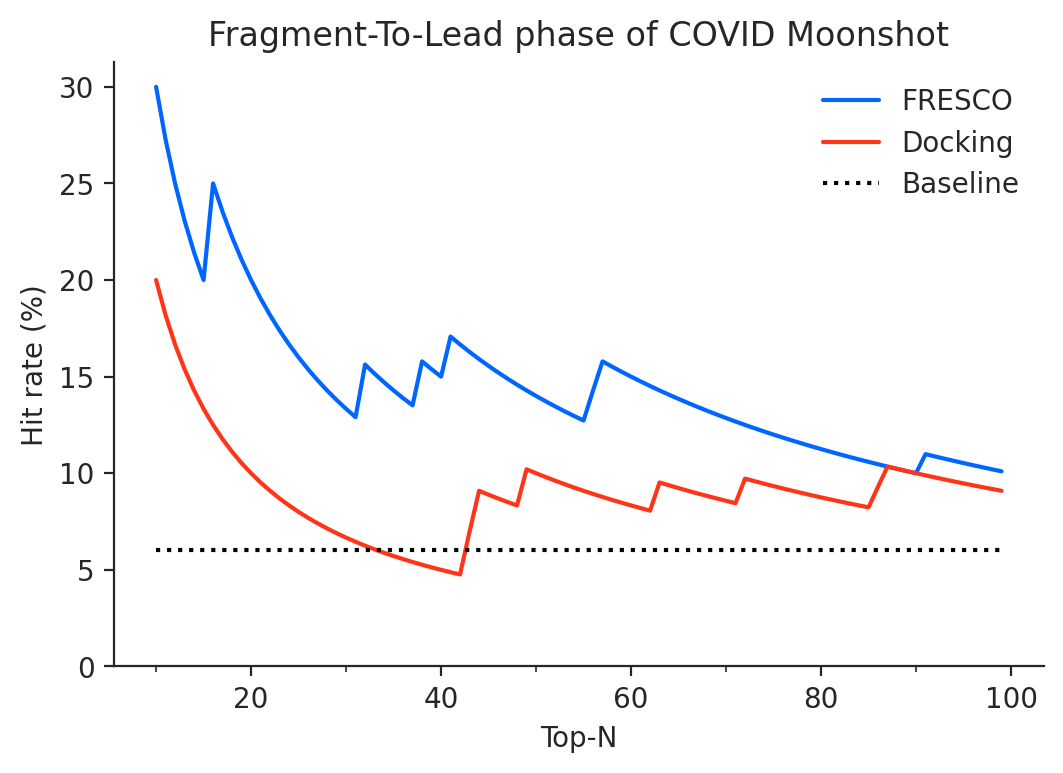

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
year = '2020'
month = '09'
day = '01'
date_to_plot = int(f'{year}{month}{day}')
ic50_threshold = 5

df_filtered_by_date = df_merged.query('date < @date_to_plot').copy()
df_filtered_by_date['hit'] = df_filtered_by_date['f_avg_IC50'] < ic50_threshold

starting_number = 10
stop_number = 100
n_list = np.linspace(start=starting_number, stop=stop_number,
                     num=stop_number-starting_number, endpoint=False)

EF_docking = [calculate_enrichment_for_df(
    df_filtered_by_date, n=int(n), index='hit', score='Chemgauss4 Score', ascending=True) for n in n_list]
EF_fresco = [calculate_enrichment_for_df(
    df_filtered_by_date, n=int(n), index='hit', score='xray_fresco_score', ascending=False) for n in n_list]

orig_prop = 100*len(
    df_filtered_by_date[df_filtered_by_date['hit']])/len(df_filtered_by_date)

sns.set_style('white')
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True

fig = plt.figure(dpi=200)
ax = plt.gca()
df_docking = pd.DataFrame({'N': n_list, 'EF': EF_docking, 'method': 'Docking'})
df_fresco = pd.DataFrame({'N': n_list, 'EF': EF_fresco, 'method': 'FRESCO'})
# df_true = pd.DataFrame({'N': n_list, 'EF': EF_true, 'method': 'True'})

df_merged_enrichment = pd.concat([df_fresco, df_docking]).reset_index()

df_merged_enrichment['EF'] = df_merged_enrichment['EF']*orig_prop

sns.lineplot(data=df_merged_enrichment, x='N', y='EF',
             hue='method', ax=ax, palette=['#0066FF', '#FF3519'])
sns.despine()
plt.plot(n_list, np.ones_like(n_list)*orig_prop, 'k:', label='Baseline')
ax.xaxis.set_major_locator(MultipleLocator(20))

# For the minor ticks, use no labels; default NullFormatter.
ax.xaxis.set_minor_locator(MultipleLocator(10))
plt.legend(loc='upper right', frameon=False)
# plt.title(f'Fragment-To-Lead phase of COVID Moonshot\n$N_{{{"data"}}}$={len(df_filtered_by_date)}, Hit = IC50<{ic50_threshold}µM')
plt.title(f'Fragment-To-Lead phase of COVID Moonshot')
plt.xlabel(f'Top-N')
plt.ylabel(f'Hit rate (%)')
plt.ylim(bottom=0)

# print(df_merged_enrichment.query('method == "FRESCO"')['EF']*n_list/100)
# print(df_merged_enrichment.query('method == "Docking"')['EF']*n_list/100)


Adding a line break

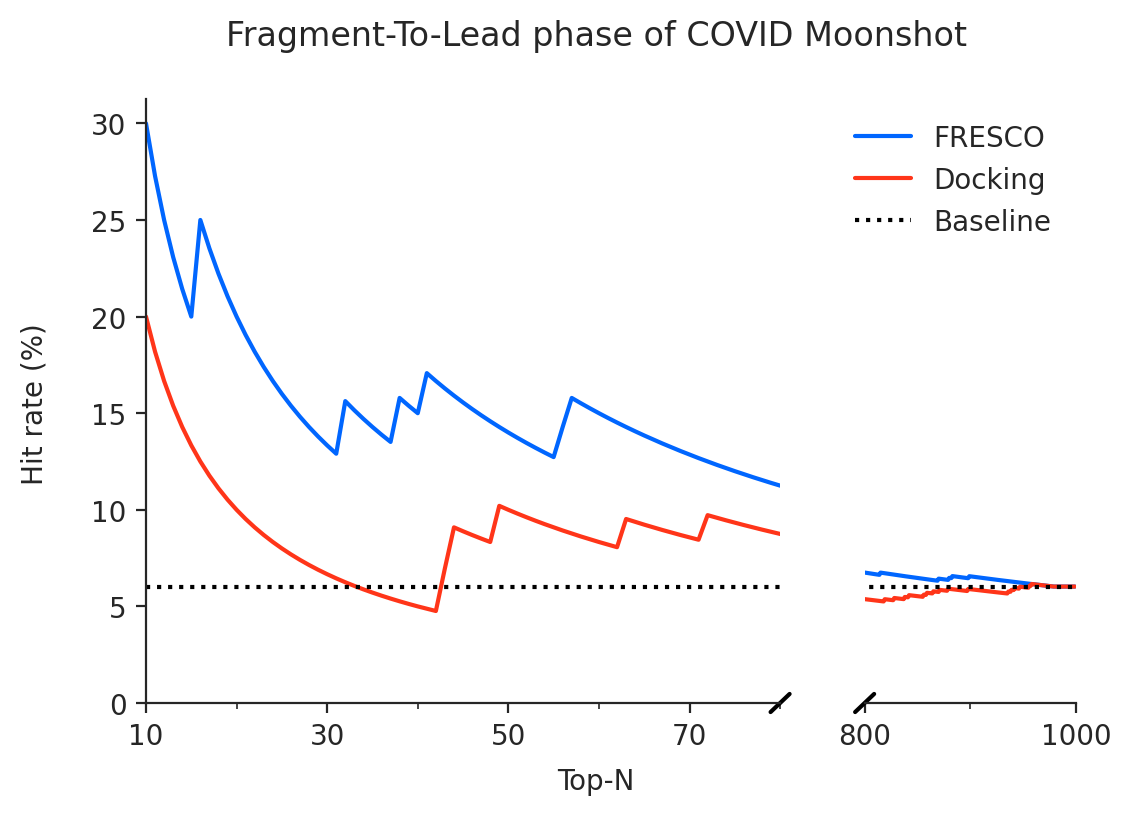

In [104]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

csfont = {'fontname':'Helvetica Neue'}

year = '2020'
month = '09'
day = '01'
date_to_plot = int(f'{year}{month}{day}')
ic50_threshold = 5

df_filtered_by_date = df_merged.query('date < @date_to_plot').copy()
df_filtered_by_date['hit'] = df_filtered_by_date['f_avg_IC50'] < ic50_threshold

starting_number = 10
stop_number = 1000
n_list = np.linspace(start=starting_number, stop=stop_number,
                     num=stop_number-starting_number, endpoint=False)

EF_docking = [calculate_enrichment_for_df(
    df_filtered_by_date, n=int(n), index='hit', score='Chemgauss4 Score', ascending=True) for n in n_list]
EF_fresco = [calculate_enrichment_for_df(
    df_filtered_by_date, n=int(n), index='hit', score='xray_fresco_score', ascending=False) for n in n_list]

orig_prop = 100*len(
    df_filtered_by_date[df_filtered_by_date['hit']])/len(df_filtered_by_date)

sns.set_style('white')
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True

f, (ax, ax2) = plt.subplots(1, 2, dpi=200, gridspec_kw={'width_ratios': [3, 1]})
# plt.title(f'Fragment-To-Lead phase of COVID Moonshot\n$N_{{{"data"}}}$={len(df_filtered_by_date)}, Hit = IC50<{ic50_threshold}µM')
plt.suptitle(f'Fragment-To-Lead phase of COVID Moonshot', **csfont)


df_docking = pd.DataFrame({'N': n_list, 'EF': EF_docking, 'method': 'Docking'})
df_fresco = pd.DataFrame({'N': n_list, 'EF': EF_fresco, 'method': 'FRESCO'})
# df_true = pd.DataFrame({'N': n_list, 'EF': EF_true, 'method': 'True'})

df_merged_enrichment = pd.concat([df_fresco, df_docking]).reset_index()

df_merged_enrichment['EF'] = df_merged_enrichment['EF']*orig_prop


def make_plot(axis):
    sns.lineplot(data=df_merged_enrichment, x='N', y='EF',
                hue='method', ax=axis, palette=['#0066FF', '#FF3519'])
    sns.despine(ax=axis)
    axis.plot(n_list, np.ones_like(n_list)*orig_prop, 'k:', label='Baseline')
   

make_plot(ax)
ax.xaxis.set_major_locator(MultipleLocator(20))
ax.xaxis.set_minor_locator(MultipleLocator(10))
ax.set_xticks([10, 30, 50, 70])
ax.set_ylim(bottom=0)
ax.set_xlim(10, 80)
ax.get_legend().remove()
ax.set_xlabel(None)
ax.set_ylabel(None)
# ax.set_ylabel(f'Hit rate (%)')

make_plot(ax2)
ax2.xaxis.set_major_locator(MultipleLocator(200))
ax2.xaxis.set_minor_locator(MultipleLocator(100))
ax2.set_ylim(bottom=0)
ax2.set_xlim(800, 1000)
ax2.legend(loc='upper right', frameon=False)
ax2.set_xlabel(None)
ax2.set_ylabel(None)

ax2.get_yaxis().set_ticks([])
# ax.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)

d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((1-d, 1+d), (-d, +d), **kwargs)


kwargs.update(transform=ax2.transAxes)  
ax2.plot((-d*3, +d*3), (-d, +d), **kwargs)

f.supxlabel('Top-N', fontsize=10)
f.supylabel('Hit rate (%)', fontsize=10)
# f.patch.set_facecolor('white')
# ax.set_facecolor('white')
# ax2.set_facecolor('white')
f.savefig('/home/wjm41/ml_physics/frag-pcore-screen/figs/plots/fresco_vs_moonshot_break.pdf', facecolor='white')


In [ ]:
df_filtered_by_date.sort_values(by='f_avg_IC50', ascending=True)


,Chemgauss4 Score,f_avg_IC50,xray_fresco_score,random_fresco_score,docked_fresco_score,docked_5_fresco_score,docked_dsi_fresco_score,canonical_CID,hit,submission_id,num_mols,contributor,year,month_name,day,time,month,date,Neg Dock Score
880,-1.40911,0.030060,-2.464234,-2.150469,-2.135896,-2.413694,-2.665722,JOH-MSK-46727e7b-1,True,JOH-MSK-46727e7b,1,"Contributor: John Chodera, MSK",2020,Aug,28,16:45:12,8,20200828,1.40911
266,-8.59048,0.050000,-2.659080,-2.299505,-2.483551,-2.695385,-2.724895,ALP-POS-c59291d4-5,True,ALP-POS-c59291d4,8,"Contributor: Alpha Lee, PostEra",2020,May,27,12:25:45,5,20200527,8.59048
131,-9.38917,0.202959,-1.947711,-1.786919,-2.029873,-1.990470,-1.934423,ALP-POS-3b848b35-2,True,ALP-POS-3b848b35,5,"Contributor: Alpha Lee, PostEra",2020,Jul,19,15:51:43,7,20200719,9.38917
1004,-4.72356,0.221232,-1.865079,-1.409138,-1.878246,-1.788931,-1.866384,LON-WEI-4d77710c-76,True,LON-WEI-4d77710c,76,"Contributor: London Lab, Weizmann Institute",2020,Aug,26,15:37:28,8,20200826,4.72356
666,-10.44010,0.260667,-2.698848,-2.378877,-2.523976,-2.728257,-2.719728,EDJ-MED-c314995a-1,True,EDJ-MED-c314995a,3,"Contributor: Ed J Griffen, MedChemica Ltd",2020,Jul,25,17:58:06,7,20200725,10.44010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1574,-5.33977,NaN,-2.823808,-2.678850,-2.589643,-2.845161,-2.816484,WAR-XCH-b72a1bbc-7,False,WAR-XCH-b72a1bbc,54,"Contributor: Warren, XChem",2020,Mar,26,23:39:50,3,20200326,5.33977
1575,-1.57142,NaN,-2.650990,-2.336610,-2.541000,-2.762115,-2.764215,WAR-XCH-b72a1bbc-8,False,WAR-XCH-b72a1bbc,54,"Contributor: Warren, XChem",2020,Mar,26,23:39:50,3,20200326,1.57142
1576,-4.98645,NaN,-3.125057,-2.962226,-2.779955,-3.349338,-3.582421,WAR-XCH-b72a1bbc-9,False,WAR-XCH-b72a1bbc,54,"Contributor: Warren, XChem",2020,Mar,26,23:39:50,3,20200326,4.98645
1578,-7.62310,NaN,-2.047659,-1.899437,-1.952986,-1.960155,-1.938632,WAR-XCH-eb7b662f-4,False,WAR-XCH-eb7b662f,9,"Contributor: Warren, XChem",2020,Mar,17,10:09:37,3,20200317,7.62310


In [ ]:
import plotly.graph_objects as go

def plotly_histograms(df_to_plot, title='Not Specified!'):
    
    col_and_method_names = {
                            # 'Neg Dock Score': 'Docking',
                            # 'random_fresco_score': 'Fresco - random',
                            'xray_fresco_score': 'Fresco - Xray',
                            # 'docked_fresco_score': 'Fresco - Docked',
                            # 'docked_5_fresco_score': 'Fresco - Docked 5',
                            # 'docked_dsi_fresco_score': 'Fresco - DSI'
                            }
    
    fig = go.Figure()
    for col, method in col_and_method_names.items():
        fig.add_trace(go.Histogram(x=df_to_plot[col], name=method))

    fig.update_layout(
        width=800,
    )

    fig.show()


def plot_histogram_against_time(year='2020', month='09', day='01'):
    date_to_filter = int(f'{year}{month}{day}')
    df_filtered_by_date = df_merged.query('date < @date_to_filter').copy()

    plotly_histograms(df_filtered_by_date,
                    title=f'<br>COVID Moonshot submissions before {day}-{month}-{year}')
    return


years_to_choose_from = ['2021', '2020']
months_to_choose_from = [f'0{x}' for x in range(
    1, 10)] + [f'{x}' for x in range(10, 13)]
days_to_choose_from = [f'0{x}' for x in range(
    1, 10)] + [f'{x}' for x in range(10, 31)]
interact(plot_histogram_against_time,
         year=years_to_choose_from, month=months_to_choose_from, day=days_to_choose_from)


interactive(children=(Dropdown(description='year', index=1, options=('2021', '2020'), value='2020'), Dropdown(…

<function __main__.plot_histogram_against_time(year='2020', month='09', day='01')>